In [149]:
!pip install joblib

menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 2.2.3 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.2.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.1.0 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [151]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from nltk.tokenize import PunktSentenceTokenizer
from nltk import wordpunct_tokenize, pos_tag, RegexpParser
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) - set(['more'])
from nltk.stem import PorterStemmer
import re
import sympy
from random import randint
from collections import Counter
from functools import reduce
from keras.utils import to_categorical
import nltk
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import joblib

%matplotlib inline

In [150]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [152]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

In [153]:
numerals = set('1234567890,.-')
textuals = set('abcdefghijklmnopqrstuvwxyz-.?')

## First manipulations

### Train

In [154]:
train = pd.read_json('/floyd/input/datahack/number_word_std.dev.json')
train.set_index('index', inplace=True)
train = train.loc[:,['text', 'equations', 'ans_simple']]
train.text = train.text.str.lower()
train.head()

,text,equations,ans_simple
index,,,
1043,one number is 11 more than another number. fin...,"[unkn: x,y, equ: x=y+11, equ: 3*x=4*y+4]","[40, 29]"
1617,one number is 3 less than a second number. twi...,"[unkn: x,y, equ: x + 3 = y, equ: 2*y + 12 = 5*x]","[6, 9]"
49,find two numbers whose sum is 62 and whose dif...,"[unkn: x,y, equ: x+y=62, equ: x-y=6]","[34, 28]"
1032,the sum of two numbers is 68. their difference...,"[unkn: x,y, equ: x+y=68, equ: x-y=16]","[42, 26]"
1256,the sum of two numbers is 97. the difference o...,"[unkn: x,y, equ: x+y=97, equ: x-y=57]","[77, 20]"


### Test

In [155]:
test = pd.read_json('/floyd/input/datahack/number_word_std.test.json')
test.set_index('index', inplace=True)
test = test.loc[:,['text', 'equations', 'ans_simple']]
test.text = test.text.str.lower()
test.head()

,text,equations,ans_simple
index,,,
1001,the difference of two integers is 9. five time...,"[unkn: x,y, equ: x-y=9, equ: 5*y=3*x+7]","[26, 17]"
1175,two numbers differ by 3. four times the lesser...,"[unkn: x,y, equ: x-y=3, equ: 4*y-3*x=7]","[16, 19]"
1269,one number is 9 more than the other number. t...,"[unkn: x,y, equ: x = y + 9, equ: 7*y - 2*x = 157]","[44, 35]"
0,the difference between two numbers is -38. two...,"[unkn: x,y, equ: x-y=(-38), equ: 2*x-5*y=(-217)]","[9, 47]"
1734,one number is 4 less than another. the differe...,"[unkn: x, y, equ: x = y - 4, equ: 2*x - 5*y = ...","[-3, 1]"


### Remove commas from number representation

In [156]:
def remove_commas_from_numbers(text):
    return ' '.join([(s.replace(',', '') if set(s) <= numerals else s) for s in text.split()])

In [157]:
# Example
# remove_commas_from_numbers('I have 2,123 ILS')
# remove_commas_from_numbers('I gave me 2,123.')

### Train

In [158]:
train.text = train.text.apply(remove_commas_from_numbers)

### Test

In [159]:
test.text = test.text.apply(remove_commas_from_numbers)

## Filtering questions in the train

#### Problematic syntax

In [160]:
def is_legit_token(token):
    if set(token) <= numerals:
        return True
    if set(token) <= textuals:
        return True
    return False

In [161]:
# Examples:
# [is_legit_token(x) for x in ['ab', '12', 'a1', '12.', 'ab.']]

In [162]:
def is_syntactic(text):
    return all(map(is_legit_token, text.split()))

In [163]:
# Examples of problematic texts
# train.loc[~train.text.apply(is_syntactic)].text.sample(5).values

In [164]:
train = train.loc[train.text.apply(is_syntactic)]

#### Too-difficult

In [165]:
forbidden_words = ['consecutive', 'reciprocal', 'factor', 'factors', 
                   'product', 'digit', 'many', 'square', 'squares', 
                   'sequence', 'opposite', 'quotient', 'first 100', 
                   'multiples', 'next', '+', '%', '^', '/']
pure_indices = []
for idx, text in train.text.iteritems():
    conteminated = any((forbidden in text for forbidden in forbidden_words))
    if not conteminated:
        pure_indices.append(idx)

In [166]:
train = train.loc[pure_indices]

In [167]:
len(train)

64

# Preprocessing

## Replace numeric laterals

* 'one' & 'two' are excluded
* 'twice' is replaced by 'two times'

In [168]:
rep = {'three': '3', 'four': '4', 
       'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 
       'nine': '9', 'ten': '10', 'eleven': '11', 'twelve': '12',
       'twice': 'two times','fifteen': '15'}

In [169]:
def rep_string_numerals(text):
    return reduce(lambda x, y: x.replace(y[0], y[1]), rep.items(),  text)

### Train

In [170]:
train.text = train.text.map(rep_string_numerals)
train.text.head()

index
1043    one number is 11 more than another number. fin...
1617    one number is 3 less than a second number. two...
49      find two numbers whose sum is 62 and whose dif...
1032    the sum of two numbers is 68. their difference...
1256    the sum of two numbers is 97. the difference o...
Name: text, dtype: object

### Test

In [171]:
test.text = test.text.map(rep_string_numerals)
test.text.head()

index
1001    the difference of two integers is 9. 5 times t...
1175    two numbers differ by 3. 4 times the lesser di...
1269    one number is 9 more than the other number. th...
0       the difference between two numbers is -38. two...
1734    one number is 4 less than another. the differe...
Name: text, dtype: object

## Tokenizing

Using wordpunkt due to the point at the end of the sentences.

In [172]:
#train.text

### Train

In [173]:
train.text = train.text.map(wordpunct_tokenize)
train.text.head()

index
1043    [one, number, is, 11, more, than, another, num...
1617    [one, number, is, 3, less, than, a, second, nu...
49      [find, two, numbers, whose, sum, is, 62, and, ...
1032    [the, sum, of, two, numbers, is, 68, ., their,...
1256    [the, sum, of, two, numbers, is, 97, ., the, d...
Name: text, dtype: object

### Test

In [174]:
test.text = test.text.map(wordpunct_tokenize)
test.text.head()

index
1001    [the, difference, of, two, integers, is, 9, .,...
1175    [two, numbers, differ, by, 3, ., 4, times, the...
1269    [one, number, is, 9, more, than, the, other, n...
0       [the, difference, between, two, numbers, is, -...
1734    [one, number, is, 4, less, than, another, ., t...
Name: text, dtype: object

## Clean stopwords

In [175]:
def clean_stopwords(lst):
    return list(filter(lambda token: token not in stop_words, lst))

### Train

In [176]:
train.text = train.text.map(clean_stopwords)
train.text.head()

index
1043    [one, number, 11, more, another, number, ., fi...
1617    [one, number, 3, less, second, number, ., two,...
49      [find, two, numbers, whose, sum, 62, whose, di...
1032    [sum, two, numbers, 68, ., difference, 16, ., ...
1256    [sum, two, numbers, 97, ., difference, two, nu...
Name: text, dtype: object

### Test

In [177]:
test.text = test.text.map(clean_stopwords)
test.text.head()

index
1001    [difference, two, integers, 9, ., 5, times, sm...
1175    [two, numbers, differ, 3, ., 4, times, lesser,...
1269    [one, number, 9, more, number, ., difference, ...
0       [difference, two, numbers, -, 38, ., two, time...
1734    [one, number, 4, less, another, ., difference,...
Name: text, dtype: object

## Stemming

In [178]:
stemmer = PorterStemmer()

In [179]:
def stem_tokens(lst):
    return [stemmer.stem(token) for token in lst]

### Train

In [180]:
train.text = train.text.apply(stem_tokens)
train.text.head()

index
1043    [one, number, 11, more, anoth, number, ., find...
1617    [one, number, 3, less, second, number, ., two,...
49      [find, two, number, whose, sum, 62, whose, dif...
1032    [sum, two, number, 68, ., differ, 16, ., numbe...
1256    [sum, two, number, 97, ., differ, two, number,...
Name: text, dtype: object

### Test

In [181]:
test.text = test.text.apply(stem_tokens)
test.text.head()

index
1001    [differ, two, integ, 9, ., 5, time, smaller, 7...
1175    [two, number, differ, 3, ., 4, time, lesser, d...
1269    [one, number, 9, more, number, ., differ, 7, t...
0       [differ, two, number, -, 38, ., two, time, sma...
1734    [one, number, 4, less, anoth, ., differ, two, ...
Name: text, dtype: object

# Data enrichment

Only for equations with full-compatibility between the numbers in the question to the numbers in the equations.

In [182]:
nums_in_text = train.text.apply(lambda lst: sorted([x for x in lst if x.isdigit()]))

In [183]:
nums_in_equations = train.equations.apply(lambda lst: sorted(re.findall('\d+', ' '.join(lst))))

In [184]:
compare = pd.DataFrame({'nums_in_equations': nums_in_equations, 'nums_in_text': nums_in_text})
compare.head()

,nums_in_equations,nums_in_text
index,,
1043,"[11, 3, 4, 4]","[11, 3, 4, 4]"
1617,"[12, 2, 3, 5]","[12, 3, 5]"
49,"[6, 62]","[6, 62]"
1032,"[16, 68]","[16, 68]"
1256,"[57, 97]","[57, 97]"


In [185]:
enriched_questions = train.loc[compare.nums_in_equations == compare.nums_in_text]
len(enriched_questions)

33

### Same numbers exactly

In [186]:
nums_in_equations = train.equations.apply(lambda lst: sorted(re.findall('\d+', ' '.join(lst))))

In [187]:
same_nums = train.loc[nums_in_equations == nums_in_text].index
enriched_questions = enriched_questions.loc[enriched_questions.index.isin(same_nums)]
len(enriched_questions)

33

### Enrichment

In [188]:
def enrich_single(tokenized, eqs, n=5):
    texts = []
    equations = []     
    
    nums = list(filter(lambda token: token.isdigit(), tokenized))
   
    for i in range(n):
        reps = [str(randint(-100, 100)) for _ in nums]
        rep_dict = dict(zip(nums, reps))  
        
        f1 = lambda token: rep_dict[token] if token in rep_dict else token
        new_text = [f1(token) for token in tokenized]
        texts.append(new_text)
        
        f2 = lambda sent: reduce(lambda text, rep_tup: text.replace(*rep_tup), rep_dict.items(), sent)
        new_eqns = [f2(eq) for eq in eqs]
        equations.append(new_eqns)
    
    return list(zip(texts, equations))

In [189]:
def enrich(questions, n=1000):
    pairs = []
    for idx, x in questions.iterrows():
        pairs.extend(enrich_single(x.text, x.equations, n))
    return pairs

In [190]:
texts, eqs = list(zip(*enrich(enriched_questions)))
train_enriched = pd.DataFrame({'text': texts, 'equations': eqs})
train_enriched.shape

(33000, 2)

In [191]:
train_enriched.sample(10)

,text,equations
8704,"[number, -16, less, anoth, ., sum, number, 3, ...","[unkn: m,n, equ: m = n - -16, equ: m + n = 3]"
28960,"[think, number, multipli, 97, answer, 52, ., n...","[unkn: x, equ: 97*x=52]"
15467,"[77, time, number, -31, more, -69, time, numbe...","[unkn: x, equ: 77*x=-69*x+--691]"
8978,"[number, -52, less, anoth, ., sum, number, 17,...","[unkn: m,n, equ: m = n - -52, equ: m + n = 17]"
15696,"[-30, time, number, 76, more, 21, time, number...","[unkn: x, equ: -210*x=21*x+76]"
14099,"[sum, two, number, 37, ., 73, time, one, numbe...","[unkn: x,y, equ: x + y = -447, equ: 7-44*x - -..."
32964,"[11, more, number, 22, time, number, ., number...","[unkn: n, equ: n + 11 = 22*n]"
20715,"[sum, two, number, -48, ., one, number, 10, ti...","[unkn: x,y, equ: x=10*y, equ: x+y=-48]"
29602,"[differ, two, number, 51, ., second, 49, less,...","[unkn: x,y, equ: x-y=891, equ: y = 89*x - 49]"
32510,"[6, more, number, 14, time, number, ., number, ?]","[unkn: n, equ: n + 6 = 14*n]"


### Concatenate the train dataframe and enriched dataframe

In [192]:
train_data_frame_to_concat = train[['equations','text']]
train = pd.concat([train_data_frame_to_concat,train_enriched], ignore_index=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [193]:
train.shape

(33064, 2)

In [194]:
train.head()

,equations,text
0,"[unkn: x,y, equ: x=y+11, equ: 3*x=4*y+4]","[one, number, 11, more, anoth, number, ., find..."
1,"[unkn: x,y, equ: x + 3 = y, equ: 2*y + 12 = 5*x]","[one, number, 3, less, second, number, ., two,..."
2,"[unkn: x,y, equ: x+y=62, equ: x-y=6]","[find, two, number, whose, sum, 62, whose, dif..."
3,"[unkn: x,y, equ: x+y=68, equ: x-y=16]","[sum, two, number, 68, ., differ, 16, ., numbe..."
4,"[unkn: x,y, equ: x+y=97, equ: x-y=57]","[sum, two, number, 97, ., differ, two, number,..."


### Unify common bigrams

In [195]:
ubigrams = set(['two number', 'one number', 'second number', 'anoth number'])
# NOTE: 'smaller number' is not ok because it can refer to both directions. 
# 'smaller' should be a unigram

In [196]:
def replace_ubigrams(lst):   
    text = ' '.join(lst)
    for ubigram in ubigrams:
        unigram = '_'.join(ubigram.split())
        text = text.replace(ubigram, unigram)
    return text.split()

### Train

In [197]:
train['text'] = train['text'].apply(replace_ubigrams)

### Test

In [198]:
test['text'] = test['text'].apply(replace_ubigrams)

# Tokens to index

In [199]:
def quest_len(text):
    len_sent = []
    for line in text:
        len_sent.append(len(line))
    return len_sent

len_text = np.array(quest_len(train.text))
print(len_text)
max_len_text = max(len_text)

[17 17  9 ...  9  9  9]


In [200]:
max(len_text)

24

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.001e+03, 0.000e+00, 7.008e+03,
        2.003e+03, 0.000e+00, 3.006e+03, 0.000e+00, 3.004e+03, 2.007e+03,
        0.000e+00, 2.005e+03, 0.000e+00, 4.005e+03, 2.009e+03, 0.000e+00,
        2.005e+03, 0.000e+00, 3.004e+03, 1.002e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.002e+03, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 6. ,  6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. ,
        12.6, 13.2, 13.8, 14.4, 15. , 15.6, 16.2, 16.8, 17.4, 18. , 18.6,
        19.2, 19.8, 20.4, 21. , 21.6, 22.2, 22.8, 23.4, 24. ]),
 <a list of 30 Patch objects>)

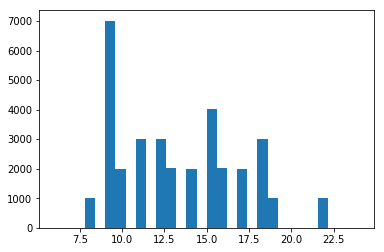

In [201]:
plt.hist(len_text,bins = 30)

# Create the dictionary of unique words and the indexes

In [202]:
list_tokens = []
for line in train['text']:
    for word in line:
        list_tokens.append(word)
list_tokens_unique = pd.unique(list_tokens)
len_list_tokens_unique = len(list_tokens_unique)
index = range(0,len_list_tokens_unique)
word_index = list(zip(list_tokens_unique,index))
word_index_dict = dict(word_index)
num_words = len(word_index)

In [203]:
def exchange_word_to_num_presentation(corpus):
    convert_words_to_seq = []
    for i,line in enumerate(corpus):
        word2num = []
        for word in line:
            if word in word_index_dict.keys():
                word2num.append(word_index_dict[word])  
            else:
                word2num.append(0)
        convert_words_to_seq.append(word2num)
    convert_words_to_seq_pad = pad_sequences(convert_words_to_seq, maxlen = max_len_text, padding='post')
    print(convert_words_to_seq_pad)
    return(convert_words_to_seq_pad)
    

### Train

In [204]:
convert_words_to_seq_train = exchange_word_to_num_presentation(train.text)
train['convert_words_to_seq'] = pd.Series(list(convert_words_to_seq_train),index=train.index)

[[  0   1   2 ...   0   0   0]
 [  0   7  14 ...   0   0   0]
 [  5   6  20 ...   0   0   0]
 ...
 [ 82   2  13 ...   0   0   0]
 [214   2  13 ...   0   0   0]
 [151   2  13 ...   0   0   0]]


### Test

In [205]:
convert_words_to_seq_train = exchange_word_to_num_presentation(test.text)
test['convert_words_to_seq'] = pd.Series(list(convert_words_to_seq_train),index=test.index)

[[23 16 35 ...  0  0  0]
 [ 6 23  7 ...  0  0  0]
 [ 0 33  2 ...  0  0  0]
 ...
 [ 5 21  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  7  0]]


In [206]:
train.head()

,equations,text,convert_words_to_seq
0,"[unkn: x,y, equ: x=y+11, equ: 3*x=4*y+4]","[one_number, 11, more, anoth_number, ., find, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 8, 12, ..."
1,"[unkn: x,y, equ: x + 3 = y, equ: 2*y + 12 = 5*x]","[one_number, 3, less, second_number, ., two, t...","[0, 7, 14, 15, 4, 16, 8, 15, 17, 14, 18, 8, 19..."
2,"[unkn: x,y, equ: x+y=62, equ: x-y=6]","[find, two_number, whose, sum, 62, whose, diff...","[5, 6, 20, 21, 22, 20, 23, 24, 4, 0, 0, 0, 0, ..."
3,"[unkn: x,y, equ: x+y=68, equ: x-y=16]","[sum, two_number, 68, ., differ, 16, ., number...","[21, 6, 25, 4, 23, 26, 4, 13, 27, 0, 0, 0, 0, ..."
4,"[unkn: x,y, equ: x+y=97, equ: x-y=57]","[sum, two_number, 97, ., differ, two_number, 5...","[21, 6, 28, 4, 23, 6, 29, 4, 5, 6, 0, 0, 0, 0,..."


In [207]:
test.head()

,text,equations,ans_simple,convert_words_to_seq
index,,,,
1001,"[differ, two, integ, 9, ., 5, time, smaller, 7...","[unkn: x,y, equ: x-y=9, equ: 5*y=3*x+7]","[26, 17]","[23, 16, 35, 33, 4, 18, 8, 12, 37, 2, 7, 8, 9,..."
1175,"[two_number, differ, 3, ., 4, time, lesser, di...","[unkn: x,y, equ: x-y=3, equ: 4*y-3*x=7]","[16, 19]","[6, 23, 7, 4, 11, 8, 93, 84, 7, 8, 85, 37, 4, ..."
1269,"[one_number, 9, more, number, ., differ, 7, ti...","[unkn: x,y, equ: x = y + 9, equ: 7*y - 2*x = 157]","[44, 35]","[0, 33, 2, 13, 4, 23, 37, 8, 12, 13, 16, 8, 9,..."
0,"[differ, two_number, -, 38, ., two, time, smal...","[unkn: x,y, equ: x-y=(-38), equ: 2*x-5*y=(-217)]","[9, 47]","[23, 6, 39, 116, 4, 16, 8, 12, 13, 54, 18, 8, ..."
1734,"[one_number, 4, less, anoth, ., differ, two, t...","[unkn: x, y, equ: x = y - 4, equ: 2*x - 5*y = ...","[-3, 1]","[0, 11, 14, 42, 4, 23, 16, 8, 12, 18, 8, 9, 13..."


# Equation

In [208]:
def is_linear(original_string_equation):
    """ Checks if an equation is linear"""
    try:    
        # Strips the 'equ:"
        strip_equ = original_string_equation.lstrip("equ: ")
        # Adds '*' where missing like in 2(k+1) to 2*(k+1)
        reg = re.findall('\d+\(', strip_equ)
        for item in reg:
            reg_with_mul = reg[0][0] + "*" + reg[0][1]
            strip_equ = strip_equ.replace(item, reg_with_mul)
        # Finds the variables
        list_of_var = []
        variables = ""
        for char in strip_equ:
            if char in "abcdefghijklmnopqrstuvwxyxABCDEFGHIJKLMNOPQRSTUVWXYZ":
                if char not in list_of_var:
                    variables = variables + char + " "
                    list_of_var.append(char)
        # Generates an Eq object for separation of the sides of equation
        eq_S = sympy.Eq(*map(sympy.S, strip_equ.split("=")))
        # Combines two sides of the equation
        final_version = eq_S.args[0] + eq_S.args[1]*-1
        # Put it in a list so that the 'linear_eq_to_matrix' can handle
        if final_version.args_cnc()[0] == []:
            final_as_list = final_version.args_cnc()[1]
        else:
            final_as_list = final_version.args_cnc()[0]
        symb = sympy.symbols(variables)
        A, b = sympy.linear_eq_to_matrix(final_as_list, symb)
        if not any(list(A)) and list(b)[0] != 0:
            return False
        else:
            return True
    except:
        return False

In [209]:
def is_set_linear(list_of_equations):
    all_linear = True
    list_without_unkn = list_of_equations[1:]
    if not all(map(is_linear, list_without_unkn)):
        return False
    else:
        return True

In [210]:
N_PARAMS = 3
def convert_equation_to_vector(original_string_equation):
    """ Converts an equation to a list of parameters of linear combination""" 
    
    # Strips the 'equ:"
    strip_equ = original_string_equation.lstrip("equ: ")
    # Adds '*' where missing like in 2(k+1) to 2*(k+1)
    reg = re.findall('\d+\(', strip_equ)
    for item in reg:
        reg_with_mul = reg[0][0] + "*" + reg[0][1]
        strip_equ = strip_equ.replace(item, reg_with_mul)
    # Finds the variables
    list_of_var = []
    variables = ""
    for char in strip_equ:
        if char in "abcdefghijklmnopqrstuvwxyxABCDEFGHIJKLMNOPQRSTUVWXYZ":
            if char not in list_of_var:
                variables = variables + char + " "
                list_of_var.append(char)
    # Generates an Eq object for separation of the sides of equation
    eq_S = sympy.Eq(*map(sympy.S, strip_equ.split("=")))
    # Combines two sides of the equation
    final_version = eq_S.args[0] + eq_S.args[1]*-1
    # Put it in a list so that the 'linear_eq_to_matrix' can handle
    if final_version.args_cnc()[0] == []:
        final_as_list = final_version.args_cnc()[1]
    else:
        final_as_list = final_version.args_cnc()[0]
    symb = sympy.symbols(variables)
    A, b = sympy.linear_eq_to_matrix(final_as_list, symb)
    negative_b = list(b)[0]
    A_params = list(A)
    params = [*list(A)] #, list(b)[0]*-1]
    # Now vectorizing
    param_A_vector = np.zeros((N_PARAMS,))
    for i, num in enumerate(params):
        param_A_vector[i] = num
    param_vector = np.hstack((param_A_vector, list(b)[0]*-1))
    param_vector_with_closure = np.hstack((8888, param_vector, 9999)) # 8888 - start equation; 9999 - end equation
    
    return param_vector_with_closure

In [211]:
N_EQUATIONS = 3
def form_vectorized_matrix(list_of_unkn_and_equations):
    """Generates a vectoer based on the equations parameters"""
    
    matrix = np.zeros((N_EQUATIONS, N_PARAMS+3)) # Added 3, one for the b in the matrix, and two for the 9999/8888 breakers
    list_of_equtions = list_of_unkn_and_equations[1:]
    for i, equaition in enumerate(list_of_equtions):
        vector = convert_equation_to_vector(equaition)
        matrix[i] = vector
    vectorized_matrix = matrix.reshape(N_EQUATIONS * (N_PARAMS+3),)
    
    return vectorized_matrix

In [212]:
train['is_linear'] = train['equations'].map(is_set_linear)

In [213]:
len(train)

33064

In [214]:
# def delete_non_linear(data_frame):
#     indexes_of_lines_to_delete = data_frame[data_frame.is_linear == False].index
#     data_frame.drop(index = indexes_of_lines_to_delete, inplace = True)
#     print('There were deleted ' + str(len(indexes_of_lines_to_delete)) + ' lines because of non-linearity')

In [215]:
train = train[train["is_linear"]]
len(train)

32839

In [216]:
train[train["is_linear"] == False]

,equations,text,convert_words_to_seq,is_linear


In [217]:
decoder_target = []
non_convertibles = []
for i, row in tqdm(train.iterrows()):
    try:
        vect = form_vectorized_matrix(row.equations)
        decoder_target.append(vect)
    except:
        non_convertibles.append(i)
        print("non")

non
non
non
non
non
non
non
non
non
non
non
non
non
non
non
non



In [218]:
# joblib.dump(decoder_target, 'decoder_target_1000')

In [219]:
# decoder_target = joblib.load('decoder_target_1000')

In [220]:
# non_convertibles

In [221]:
len(train), len(decoder_target)

(32839, 32823)

In [222]:
train.drop(non_convertibles, inplace=True)

In [223]:
len(decoder_target)

32823

In [224]:
len(train)

32823

In [225]:
decoder_target_mat = np.array([np.array(x) for x in decoder_target])
unique_eq_char = pd.Series(decoder_target_mat.flatten()).unique()
num_words_output = len(unique_eq_char)

In [226]:
eq_index = dict([(val, i) for i, val in enumerate(unique_eq_char)])

In [227]:
decoder_target_new = []
for line in decoder_target:
    temp_vec = []
    for char in line:
        temp_vec.append(eq_index[char])
    decoder_target_new.append(temp_vec)

In [228]:
# decoder_target_new

### Train

In [229]:
encoder_input = list(train.convert_words_to_seq)
len(encoder_input)

32823

In [230]:
# encoder_input

### Test

In [231]:
encoder_input_test = list(test.convert_words_to_seq)
len(encoder_input_test)

1504

In [232]:
decoder_target_input = [np.hstack((1111,line)) for line in decoder_target_new]
decoder_target_output = [np.hstack((line,2222)) for line in decoder_target_new]

In [233]:
len(decoder_target_input)
len(decoder_target_output)

32823

# The Model

In [234]:
EMBEDDING_DIM = 150
max_len_target = N_EQUATIONS*(N_PARAMS+3) + 1 
LATENT_DIM = 220
max_len_text = len(encoder_input[0])

In [235]:
len(encoder_input[0])

24

In [236]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  #weights=[embedding_matrix],
  input_length=max_len_text,
  # trainable=True
)

In [237]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(train),
    max_len_target,
    num_words_output 
  ),
  dtype='float32'
)

In [238]:
num_words_output

3108

In [239]:
# assign the values. So the one hot has three dimensions: the first is the 10000 data rows, the second is the 7 words of the 
# target, and the third is the 'num_word_output' which is the number of unique words in the target. So the 'word' varaible is the
# value in the 'decoder_output', for example 147, so this will be the index in the third dimension of the one_hot
for i, d in enumerate(decoder_target_output):
    for t, word in enumerate(d):
        try:
            decoder_targets_one_hot[i, t, word] = 1
        except:
            pass#print(i, d, word)

In [240]:
decoder_targets_one_hot.shape

(32823, 19, 3108)

In [241]:
max_len_text

24

In [242]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_text,))

embed_encod = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True, # Because I use return_state=True I can have h and c, otherwise I would get only the encoder outputs
  #dropout=0.3 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(embed_encod)
# encoder_outputs, h = encoder(embed_encod) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,)) # Important. I am using the max_len of the target(!) here

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  #dropout=0.3 # dropout not available on gpu
)
# Below - like the encoder receives an input of 'embed_encode', here are two inputs: 1. the target text, represented by 
# decoder_input_x, 2. the the encoder_state (h,c) from the encoder
# Also, I don't need the h and c as outputs (as I willl need them in the prediction)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [243]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [244]:
# Compile the model

# from keras import optimizers
# epochs = 50
# learning_rate = 0.0007
# decay_rate = learning_rate / epochs
# adam = optimizers.Adam(lr=learning_rate, decay=decay_rate, amsgrad=False)

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [245]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 24)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 19)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 24, 150)      39000       input_6[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 19, 220)      683760      input_7[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm

In [246]:
BATCH_SIZE = 160
EPOCHS = 50

In [247]:
# Train the model
r = model.fit(
  [encoder_input, decoder_target_input], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
  verbose=1,
)

Train on 26258 samples, validate on 6565 samples
Epoch 1/50
26258/26258 [==============================] - 18s 691us/step - loss: 2.4307 - acc: 0.5396 - val_loss: 2.0390 - val_acc: 0.6498
Epoch 2/50
26258/26258 [==============================] - 17s 660us/step - loss: 1.4254 - acc: 0.7369 - val_loss: 1.4499 - val_acc: 0.7636
Epoch 3/50
26258/26258 [==============================] - 17s 660us/step - loss: 1.0139 - acc: 0.8055 - val_loss: 1.7849 - val_acc: 0.6812
Epoch 4/50
26258/26258 [==============================] - 17s 664us/step - loss: 0.9046 - acc: 0.8443 - val_loss: 1.3844 - val_acc: 0.8067
Epoch 5/50
26258/26258 [==============================] - 17s 661us/step - loss: 0.8561 - acc: 0.8626 - val_loss: 1.4097 - val_acc: 0.8112
Epoch 6/50
26258/26258 [==============================] - 17s 657us/step - loss: 0.8325 - acc: 0.8642 - val_loss: 3.2211 - val_acc: 0.5882
Epoch 7/50
26258/26258 [==============================] - 17s 650us/step - loss: 0.8192 - acc: 0.8638 - val_loss: 1.3

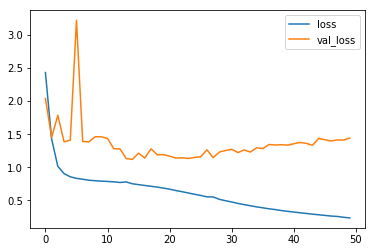

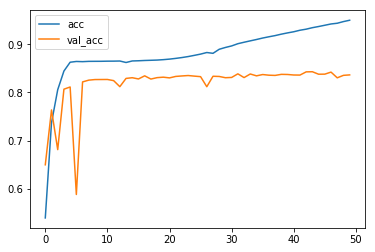

In [248]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [249]:
##### Make predictions #####
# We need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone. It is exactly as the encoder in the training model
# From this we will get our initial decoder hidden state (h,c)
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [250]:
# These inputs are placeholders for the output of the encoder_model above
decoder_state_input_h = Input(shape=(LATENT_DIM,)) 
decoder_state_input_c = Input(shape=(LATENT_DIM,)) 
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

In [251]:
decoder_inputs_single = Input(shape=(1,))
# The single word input (at its time) will be embedded
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [252]:
# this time, we want to keep the states too (h and c of the decoder), to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x, # This is the input of the generated previous word in the prediction
  initial_state=decoder_states_inputs # The h and c states from encoder_model
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru

In [253]:
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

In [254]:
# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states)

In [255]:
# map indexes back into real words
# so we can view the results (it's the opposite, v:k instead k:v)
idx2word_eng = {v:k for k, v in word_index_dict.items()}
idx2word_trans = {v:k for k, v in eq_index.items()} # nltk_word_index replaced word2idx_outputs

In [256]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = 1111 # Instead of <sos> till parsing is better (as input token). First Token

    # if we get this we break
    eos = 2222 # Instead of <eos> till parsing is better (as input token). Last Token

    # Create the translation - make prediction 7 (or any target length) times, and each time generate token, h, c
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # output_tokens, h = decoder_model.predict([target_seq] + states_value) # gru

        # Get next word
        idx = np.argmax(output_tokens[0, 0, :])

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx

        # Update states
        states_value = [h, c] # or decoder_states
        # states_value = [h] # gru
    return (output_sentence)

In [257]:
# while True:
#     # Do some test translations
#     i = np.random.choice(len(input_texts))
#     input_seq = encoder_inputs[i:i+1]
#     print(input_seq)
#     translation = decode_sequence(input_seq)
#     print('-')
#     print('Input:', input_texts[i])
#     print('Translation:', translation)

#     ans = input("Continue? [Y/n]")
#     if ans and ans.lower().startswith('n'):
#         break

**Example from test set**

In [258]:
example_input = encoder_input_test[10]
example_input

array([21,  6, 46,  4, 23, 11,  4,  5,  6,  4,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [259]:
reshaped = example_input.reshape(1,24)

In [260]:
idx2word_eng = {v:k for k, v in word_index_dict.items()}

In [261]:
question = [idx2word_eng[num] for num in example_input]
question

['sum',
 'two_number',
 '20',
 '.',
 'differ',
 '4',
 '.',
 'find',
 'two_number',
 '.',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number',
 'one_number']

In [262]:
example_translation = decode_sequence(reshaped)
example_translation

[1.0,
 1.0,
 0.0,
 -20.0,
 9999.0,
 1.0,
 -1.0,
 0.0,
 -4.0,
 9999.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

**Prediction functions**

In [263]:
end_sent = 9999
def count_eq(vector):
    vector_sep = []
    index = [i for i, x in enumerate(vector) if x == end_sent]
    for i in index: 
        vector_sep.append(list(vector[i-4:i]))
    return vector_sep

In [264]:
list_input_eq = count_eq(example_translation)
list_input_eq

[[1.0, 1.0, 0.0, -20.0], [1.0, -1.0, 0.0, -4.0]]

In [265]:
# [i for i, x in enumerate(example_translation) if x == 9999]

In [266]:
# example_translation[5:7]

In [267]:
from sympy import solve, symbols

In [268]:
def result_eq(list_input_eq):
    x1,x2,x3 = symbols('x1,x2,x3') ## sympy.symbols
    unknown = sympy.Matrix((x1,x2,x3,1))
    unknown = unknown.reshape(4,1)
    if len(list_input_eq)>0:
        a = sympy.Matrix((list_input_eq[0]))
        a = a.reshape(1,4)

        eq_num_one = a*unknown
        if len(list_input_eq)>1:
            b = sympy.Matrix((list_input_eq[1]))
            b = b.reshape(1,4)

            eq_num_two = b*unknown

            if len(list_input_eq) == 3:
                c = sympy.Matrix((list_input_eq[2]))
                c = c.reshape(1,4)
                eq_num_third = c*unknown
                result = solve([eq_num_one , eq_num_two , eq_num_third], x1,x2,x3)
                return result
            else:
                result = solve([eq_num_one , eq_num_two], x1,x2,x3)
        else:
            result = solve([eq_num_one], x1,x2,x3)
    else:
        return [0]
    return result

In [269]:
answer_dict = result_eq(list_input_eq)
answer_dict

{x2: 8.00000000000000, x1: 12.0000000000000}

In [270]:
def answer_list(var):
    result = None
    if type(var) == dict:
        result = list(var.values())
    return result

In [271]:
answer_list(answer_dict)

[8.00000000000000, 12.0000000000000]

In [272]:
from sympy import symbols

## Test data prediction

In [273]:
test = test.reset_index()

In [274]:
solution_list = []
counter = 0
for input_vect in tqdm(encoder_input_test):
    try:
        reshaped = input_vect.reshape(1,24)
        predicted_vect = decode_sequence(reshaped)
        predicted_equations = count_eq(predicted_vect)
        solution = result_eq(predicted_equations)
        solution_as_list = answer_list(solution)
        rounded_as_list = [round(x) for x in solution_as_list]
    except:
        solution = [0]
        counter +=1
    solution_list.append(rounded_as_list)

In [275]:
print("No. of errors: ",  counter)

No. of errors:  188


In [276]:
solution_list[:11]

[[6, -2],
 [-45, -1],
 [2, -5],
 [-6, 79],
 [3, -1],
 [18, 14],
 [9, 13],
 [9, 13],
 [13, 25],
 [-10, -4],
 [8, 12]]

In [277]:
test["predicted_solution"] = pd.Series(solution_list)

In [278]:
test["predicted_solution"][:11]

0       [6, -2]
1     [-45, -1]
2       [2, -5]
3      [-6, 79]
4       [3, -1]
5      [18, 14]
6       [9, 13]
7       [9, 13]
8      [13, 25]
9     [-10, -4]
10      [8, 12]
Name: predicted_solution, dtype: object

# Accuracy

In [279]:
ys = pd.DataFrame({'sol_true': test["ans_simple"], 'sol_pred': test["predicted_solution"]})

In [280]:
is_same_sol = ys.sol_true.map(set) == ys.sol_pred.map(set)
accuracy = is_same_sol.value_counts(normalize=True)

In [281]:
print("accuracy: ", accuracy[1])

accuracy:  0.011303191489361703


In [282]:
num_solved = accuracy[1]* len(ys)
print("Number of equations solved: ", num_solved)

Number of equations solved:  17.0
